In [17]:
"""
CubeSat Battery + Orbit Simulator (Balanced + Adaptive Charging)

Generates time-series data for: time_s, orbit, phase, current_A, voltage_V,
temperature_C, SoC_true, SoH_true, fault_flag

Features:
 - 90-minute orbits (configurable sun/eclipse durations)
 - Adaptive charging to maintain long-term SoC equilibrium
 - Eco-mode to reduce discharge when SoC is low
 - Mild aging (capacity fade and internal resistance increase)
 - Fault injection for ML anomaly scenarios
 - Outputs CSV and diagnostic plots

"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os

# ---------------------------
# Helper physical functions
# ---------------------------
def ocv_curve(soc):
    """
    Approximate Li-ion open-circuit voltage (OCV) curve.
    soc : [0..1]
    Returns voltage in volts.
    This is a simple polynomial approximation—tweak for more realism.
    """
    # Ensure soc in [0,1]
    soc = np.clip(soc, 0.0, 1.0)
    # Empirical-ish curve: V = 3.0 + 1.2*soc - 0.2*soc^2  -> range ~3.0..4.0
    return 3.0 + 1.2 * soc - 0.2 * soc**2

# ---------------------------
# Simulator core
# ---------------------------
def simulate_cubesat_battery_adaptive(
    n_orbits=500,
    orbit_minutes=90,
    sun_minutes=35,
    eclipse_minutes=55,
    sample_period_s=1.0,
    capacity_ah=8.0,
    r_int_Ohm=0.05,  
    env_temp_C=20.0,
    alpha_age_per_orbit=1e-5,
    beta_age_per_orbit=2e-5,
    initial_soc=0.8,
    initial_temp=20.0,
    charge_eff_init=1.02,
    adaptive_gain=0.03,
    target_soc=0.6,
    adaptive_window_orbits=5,
    fault_probability_per_orbit=0.02,
    random_seed=42,
    verbose=False,
):
    """
    Simulate battery behavior over multiple orbits with adaptive charging.

    Returns a pandas DataFrame with columns:
    ['time_s','orbit','phase','current_A','voltage_V','temperature_C','SoC_true','SoH_true','fault_flag']
    """

    # Fix variable name for R_int
    r_int = r_int_Ohm  # rename to r_int

    # Seed RNGs
    np.random.seed(random_seed)
    random.seed(random_seed)

    # Derived values
    orbit_duration_s = int(orbit_minutes * 60)
    sun_time_s = int(sun_minutes * 60)
    eclipse_time_s = int(eclipse_minutes * 60)
    samples_per_orbit = int(orbit_duration_s // sample_period_s)

    # Pre-alloc lists
    time_global = []
    current_list = []
    voltage_list = []
    temperature_list = []
    soc_list = []
    soh_list = []
    orbit_id_list = []
    phase_list = []
    fault_flag_list = []

    # Initial states
    SoC = float(initial_soc)   # fraction [0..1]
    Temp = float(initial_temp)
    SoH = 1.0
    C_nom = float(capacity_ah)
    R0 = float(r_int)

    # Thermal model params
    k_heat = 0.0025
    k_cool = 0.0015

    # Adaptive charging variable (starts slightly >1 to compensate losses)
    charge_eff = float(charge_eff_init)

    # Store orbit-average SoC history for adaptive control
    orbit_mean_soc_history = []

    # Loop orbits
    global_time_counter = 0.0
    for orb in range(n_orbits):
        # Per-orbit aging (mild)
        C_now = C_nom * max(0.5, 1.0 - alpha_age_per_orbit * orb)   # clip to 50% to avoid unrealistic zero
        R_now = R0 * (1.0 + beta_age_per_orbit * orb)
        SoH = C_now / C_nom

        # Simulate some variability in discharge (payload duty cycles)
        I_dis_base = 1.0 + 0.15 * np.sin(2 * np.pi * orb / 40.0)  # mean discharge ~1.0 A
        # Set charge to balance energy with an efficiency factor
        # Ideally: I_chg * t_sun * charge_eff + I_dis * t_eclipse = 0  => I_chg = - I_dis * (t_eclipse/t_sun)/charge_eff
        # but include charge_eff as numerator to provide slight overcharging when charge_eff > 1.
        I_dis = max(0.1, I_dis_base)
        I_chg_nominal = -I_dis * (eclipse_time_s / max(1, sun_time_s)) * charge_eff

        # Create current profile for the orbit
        # small AC ripple to simulate panel/consumption variability
        t_sun = np.arange(0, sun_time_s, sample_period_s)
        t_ecl = np.arange(sun_time_s, orbit_duration_s, sample_period_s)

        # Sun (charging) and eclipse (discharging) waveforms
        I_sun = I_chg_nominal + 0.05 * np.sin(2 * np.pi * t_sun / 400.0)
        I_ecl = I_dis + 0.25 * np.sin(2 * np.pi * t_ecl / 900.0)
        I_profile = np.concatenate([I_sun, I_ecl])

        # Fault injection per-orbit (rare)
        has_fault = random.random() < fault_probability_per_orbit
        fault_type = None
        if has_fault:
            fault_type = random.choice(['spike', 'sensor_drift', 'rint_jump', 'temp_bump'])
            # Choose a start and a small duration
            start_idx = random.randint(0, max(0, len(I_profile) - 600))
            dur = random.randint(50, 600)
            end_idx = min(len(I_profile), start_idx + dur)
            if fault_type == 'spike':
                I_profile[start_idx:end_idx] *= 2.0
            elif fault_type == 'sensor_drift':
                I_profile[start_idx:end_idx] += 0.35
            elif fault_type == 'rint_jump':
                R_now *= 1.5
            elif fault_type == 'temp_bump':
                Temp += 6.0

        # Integrate through the orbit
        soc_values_this_orbit = []
        for t_idx, I_inst in enumerate(I_profile):
            # Eco-mode: reduce discharge if SoC low (system-level power management)
            if SoC < 0.25 and I_inst > 0:
                I_inst *= 0.35  # aggressive power saving
            # Prevent overcharge when nearly full
            if SoC > 0.98 and I_inst < 0:
                I_inst *= 0.1

            # Update SoC (I positive = discharge; I negative = charging)
            delta_ah = (I_inst * sample_period_s) / 3600.0  # Ah change
            SoC -= delta_ah / max(1e-6, C_now)  # fraction
            SoC = float(np.clip(SoC, 0.0, 1.0))

            # Voltage: OCV minus IR drop + small noise
            Voc = ocv_curve(SoC)
            V_inst = Voc - I_inst * R_now + np.random.normal(0, 0.012)

            # Temperature dynamics: heat from current, cool toward environment
            Temp += k_heat * abs(I_inst) - k_cool * (Temp - env_temp_C)
            Temp += np.random.normal(0, 0.03)

            # Store sample
            time_global.append(global_time_counter)
            current_list.append(float(I_inst + np.random.normal(0, 0.03)))  # add sensor noise
            voltage_list.append(float(V_inst))
            temperature_list.append(float(Temp))
            soc_list.append(float(SoC))
            soh_list.append(float(SoH))
            orbit_id_list.append(int(orb))
            phase_list.append('sunlight' if t_idx < len(t_sun) else 'eclipse')
            fault_flag_list.append(1 if has_fault else 0)

            soc_values_this_orbit.append(SoC)
            global_time_counter += sample_period_s

        # End of orbit: compute average SoC for adaptation
        mean_soc_orbit = float(np.mean(soc_values_this_orbit))
        orbit_mean_soc_history.append(mean_soc_orbit)

        # Adaptive control: adjust charge_eff slightly based on recent mean SoC
        # Use rolling average over last "adaptive_window_orbits" orbits
        window = orbit_mean_soc_history[-adaptive_window_orbits:]
        avg_recent_soc = float(np.mean(window))
        # If avg_recent_soc is below target, increase charge efficiency (more charging)
        # If above target+margin, slightly reduce charging to avoid overcharging
        margin = 0.05
        if avg_recent_soc < (target_soc - margin):
            charge_eff *= (1.0 + adaptive_gain)   # increase by gain proportionally
        elif avg_recent_soc > (target_soc + margin):
            charge_eff *= (1.0 - adaptive_gain)
        # Constrain charge_eff to reasonable bounds
        charge_eff = float(np.clip(charge_eff, 0.96, 1.12))

        if verbose and (orb % max(1, n_orbits//10) == 0):
            print(f"Orbit {orb:4d}: mean_soc={mean_soc_orbit:.3f}, charge_eff={charge_eff:.3f}, C_now={C_now:.3f} Ah, R_now={R_now:.4f} Ohm")

    # Build DataFrame
    df = pd.DataFrame({
        'time_s': time_global,
        'orbit': orbit_id_list,
        'phase': phase_list,
        'current_A': current_list,
        'voltage_V': voltage_list,
        'temperature_C': temperature_list,
        'SoC_true': soc_list,
        'SoH_true': soh_list,
        'fault_flag': fault_flag_list
    })

    return df

# ---------------------------
# Main runner
# ---------------------------
if __name__ == "__main__":
    # Parameters - tweak to run faster or longer
    N_ORBITS = 500           # 500 orbits ~ 31 days ; set small for quick tests
    SAMPLE_PERIOD = 1.0      # 1 Hz sampling
    OUT_FILENAME = "cubesat_battery_adaptive.csv"

    # Run simulation
    df = simulate_cubesat_battery_adaptive(
        n_orbits=N_ORBITS,
        orbit_minutes=90,
        sun_minutes=35,
        eclipse_minutes=55,
        sample_period_s=SAMPLE_PERIOD,
        capacity_ah=8.0,
        r_int_Ohm=0.05,
        env_temp_C=20.0,
        alpha_age_per_orbit=1e-5,
        beta_age_per_orbit=2e-5,
        initial_soc=0.82,
        initial_temp=20.0,
        charge_eff_init=1.02,
        adaptive_gain=0.03,
        target_soc=0.6,
        adaptive_window_orbits=5,
        fault_probability_per_orbit=0.03,
        random_seed=1234,
        verbose=True
    )

    # Save CSV
    # df.to_csv(OUT_FILENAME, index=False)
    print(f"\n✅ Saved simulated dataset to: {os.path.abspath(OUT_FILENAME)}")
    print(f"Rows: {len(df):,}")


Orbit    0: mean_soc=0.879, charge_eff=0.989, C_now=8.000 Ah, R_now=0.0500 Ohm
Orbit   50: mean_soc=0.755, charge_eff=0.960, C_now=7.996 Ah, R_now=0.0500 Ohm
Orbit  100: mean_soc=0.601, charge_eff=0.960, C_now=7.992 Ah, R_now=0.0501 Ohm
Orbit  150: mean_soc=0.641, charge_eff=1.018, C_now=7.988 Ah, R_now=0.0502 Ohm
Orbit  200: mean_soc=0.547, charge_eff=1.018, C_now=7.984 Ah, R_now=0.0502 Ohm
Orbit  250: mean_soc=0.581, charge_eff=0.960, C_now=7.980 Ah, R_now=0.0502 Ohm
Orbit  300: mean_soc=0.650, charge_eff=0.960, C_now=7.976 Ah, R_now=0.0503 Ohm
Orbit  350: mean_soc=0.645, charge_eff=1.120, C_now=7.972 Ah, R_now=0.0503 Ohm
Orbit  400: mean_soc=0.599, charge_eff=0.960, C_now=7.968 Ah, R_now=0.0504 Ohm
Orbit  450: mean_soc=0.685, charge_eff=0.960, C_now=7.964 Ah, R_now=0.0757 Ohm

✅ Saved simulated dataset to: c:\Users\pc\Desktop\cubesat\generation\cubesat_battery_adaptive.csv
Rows: 2,700,000


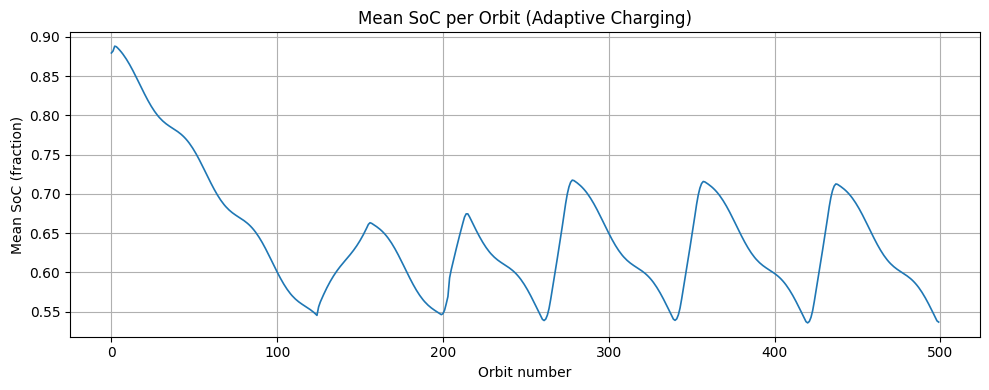

In [18]:
# Diagnostic plots
# 1) Mean SoC per orbit
mean_soc_per_orbit = df.groupby("orbit")["SoC_true"].mean()
plt.figure(figsize=(10,4))
plt.plot(mean_soc_per_orbit.index, mean_soc_per_orbit.values, lw=1.2)
plt.xlabel("Orbit number")
plt.ylabel("Mean SoC (fraction)")
plt.title("Mean SoC per Orbit (Adaptive Charging)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
# 2) Plot one sample orbit (e.g., orbit 0 and orbit near end)
def plot_sample_orbit(orbit_idx):
    sub = df[df["orbit"] == orbit_idx]
    if len(sub) == 0:
        print("No data for orbit", orbit_idx)
        return
    t_minutes = (sub["time_s"] - sub["time_s"].iloc[0]) / 60.0
    fig, axs = plt.subplots(3,1, figsize=(10,7), sharex=True)
    axs[0].plot(t_minutes, sub["voltage_V"], label="Voltage (V)")
    axs[1].plot(t_minutes, sub["current_A"], label="Current (A)", color="C1")
    axs[2].plot(t_minutes, sub["SoC_true"], label="SoC", color="C2")
    axs[0].legend(); axs[1].legend(); axs[2].legend()
    axs[2].set_xlabel("Time (minutes)")
    axs[0].grid(True); axs[1].grid(True); axs[2].grid(True)
    plt.suptitle(f"Orbit {orbit_idx} sample")
    plt.tight_layout()
    plt.show()


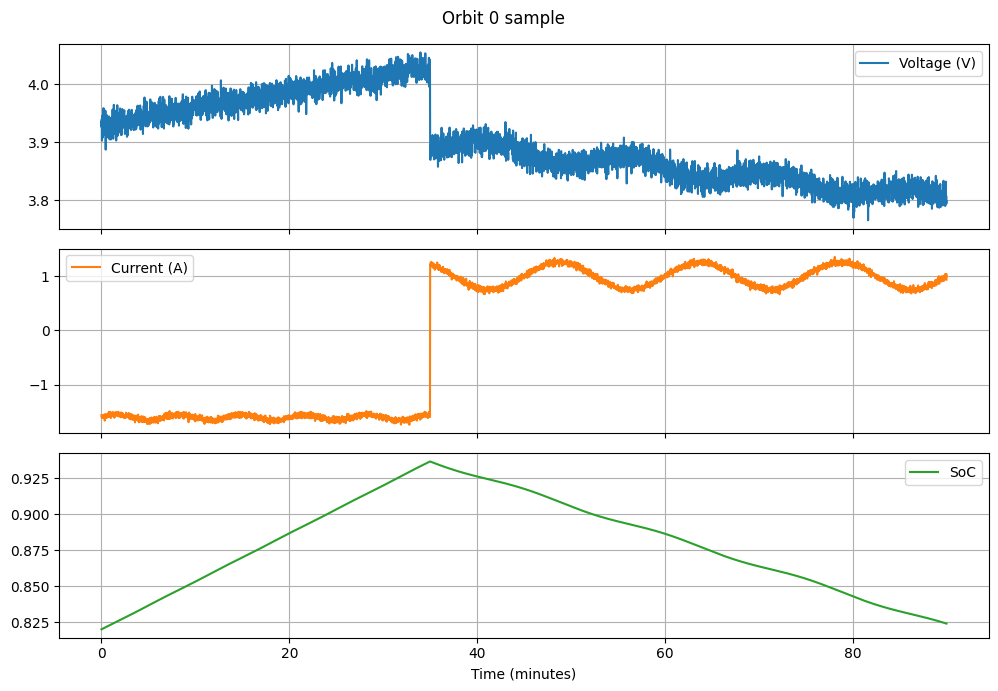

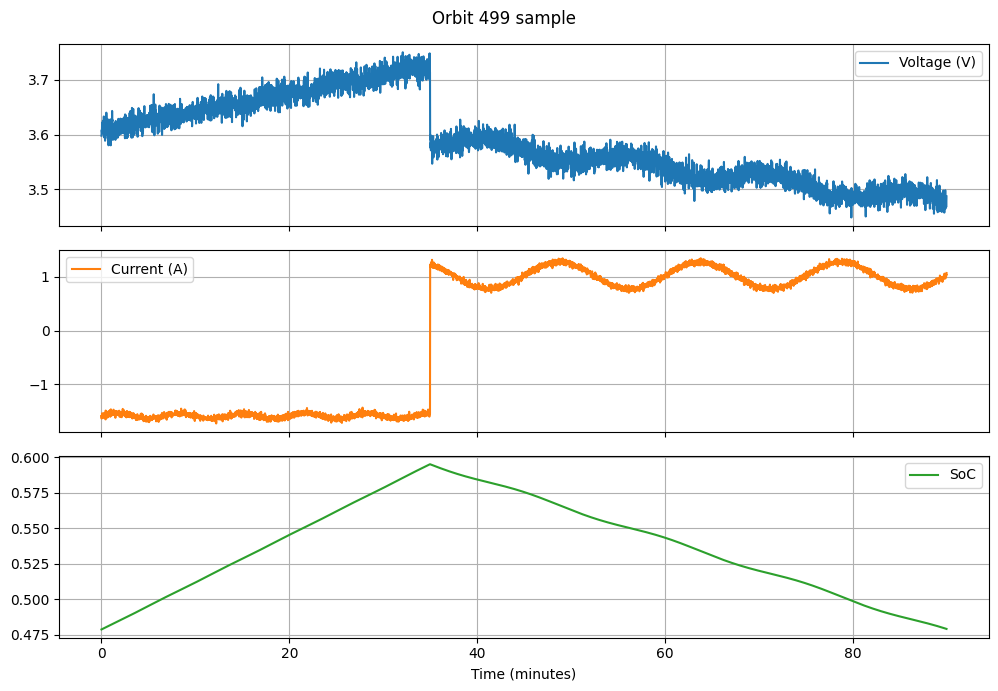

Done.


In [20]:
# Show earliest and latest orbit samples
plot_sample_orbit(0)
plot_sample_orbit(max(df["orbit"]))

print("Done.")

--- 1. Analyse du Cycle de Charge/Décharge du SOC ---


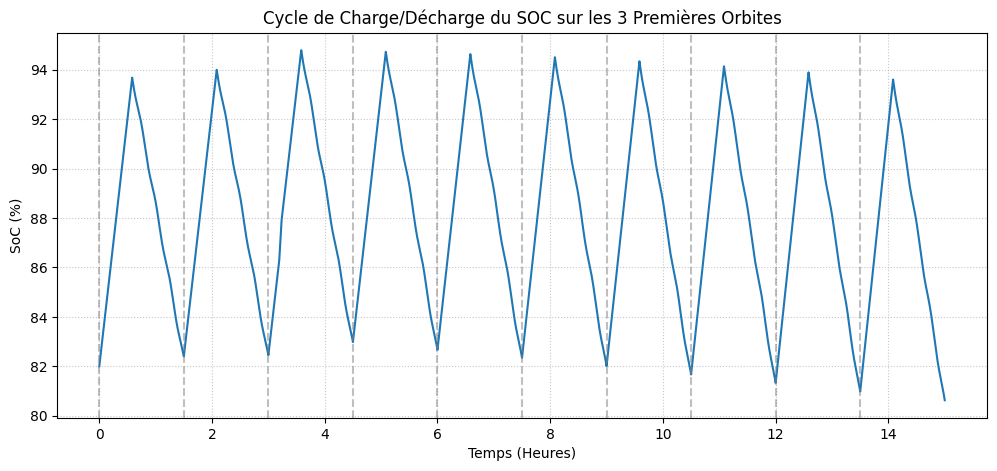

In [5]:
# --- 1. Vérification du Réalisme du Cycle Orbital (SOC) ---
print("--- 1. Analyse du Cycle de Charge/Décharge du SOC ---")
# Sélectionner les 3 premières orbites pour une visualisation claire
orbits_to_plot = df['orbit'].unique()[:10]
df_cycles = df[df['orbit'].isin(orbits_to_plot)]

plt.figure(figsize=(12, 5))
plt.plot(df_cycles['time_s'] / 3600, df_cycles['SoC_true'] * 100, label='SoC (%)')
for orb in orbits_to_plot:
    # Marquer le début de la phase d'éclipse
    eclipse_start_time = df_cycles[df_cycles['orbit'] == orb]['time_s'].iloc[0] + df_cycles[df_cycles['phase'] == 'sunlight']['time_s'].iloc[0]
    plt.axvline(x=eclipse_start_time / 3600, color='grey', linestyle='--', alpha=0.5)

plt.xlabel("Temps (Heures)")
plt.ylabel("SoC (%)")
plt.title("Cycle de Charge/Décharge du SOC sur les 3 Premières Orbites")
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

# Conclusion : Le graphique doit montrer une montée (charge) suivie d'une descente (décharge) par cycle.

In [1]:
import numpy as np
import pandas as pd
import os
import joblib
from sklearn.preprocessing import StandardScaler

# ---------------------------
# Parameters
# ---------------------------
INPUT_CSV = "cubesat_battery_adaptive.csv"
OUTPUT_X = "cubesat_X_lstm.npy"
OUTPUT_Y = "cubesat_y_lstm.npy"
OUTPUT_SCALER = "cubesat_scaler.pkl"

# --- MODIFIED PARAMETERS FOR MEMORY REDUCTION ---
WINDOW_MINUTES = 5  # Reduced window size to 5 minutes
PREDICT_AHEAD_MINUTES = 15
ORIGINAL_SAMPLE_PERIOD_S = 1.0 
DOWNSAMPLE_FACTOR = 10 # Sample once every 10 seconds instead of every 1 second
NEW_SAMPLE_PERIOD_S = ORIGINAL_SAMPLE_PERIOD_S * DOWNSAMPLE_FACTOR

FEATURES = ["current_A", "voltage_V", "temperature_C", "SoH_true", "SoC_true"]

# ---------------------------
# Load and Check Data
# ---------------------------
if not os.path.exists(INPUT_CSV):
    raise FileNotFoundError(f"Missing {INPUT_CSV}. Please run the simulator first.")

df = pd.read_csv(INPUT_CSV)
print(f"✅ Loaded dataset with {len(df):,} samples.")

# ---------------------------
# 1. Downsampling to Reduce Memory
# ---------------------------
# Keep only samples every DOWNSAMPLE_FACTOR (e.g., keep 1 sample every 10)
df_downsampled = df.iloc[::DOWNSAMPLE_FACTOR, :].reset_index(drop=True)
print(f"✅ Downsampled data to {len(df_downsampled):,} samples (1/{DOWNSAMPLE_FACTOR} size).")

# Keep only relevant columns
df_downsampled = df_downsampled[["time_s", *FEATURES]].reset_index(drop=True)

# ---------------------------
# 2. Compute time-related parameters based on new frequency
# ---------------------------
# Window size: (5 minutes * 60 seconds/min) / 10 seconds/sample = 30 samples
window_size = int(WINDOW_MINUTES * 60 / NEW_SAMPLE_PERIOD_S)
prediction_horizon = int(PREDICT_AHEAD_MINUTES * 60 / NEW_SAMPLE_PERIOD_S)

print(f"Window size: {window_size} samples (was 600)")
print(f"Prediction horizon: {prediction_horizon} samples (was 900)")

# ---------------------------
# 3. Normalize features
# ---------------------------
scaler = StandardScaler()
df_scaled = df_downsampled.copy()
# We must scale the entire dataset (X and Y) together, but only for the features
df_scaled[FEATURES] = scaler.fit_transform(df_scaled[FEATURES])
joblib.dump(scaler, OUTPUT_SCALER)
print(f"✅ Saved fitted scaler → {OUTPUT_SCALER}")

# ---------------------------
# 4. Generate 3D sequential data
# ---------------------------
X_seq, y_seq = [], []
window_data = df_scaled[FEATURES].values
target_data = df_scaled["SoC_true"].values # Target is also scaled!

# The loop now runs much faster on the smaller dataset
for i in range(len(window_data) - window_size - prediction_horizon):
    # X_window is already a NumPy array slice, which is fast and memory efficient
    X_window = window_data[i : i + window_size]
    y_future = target_data[i + window_size + prediction_horizon]
    X_seq.append(X_window)
    y_seq.append(y_future)

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# --- New Size Check ---
# Samples: ~270,000. Time Steps: 30. Features: 5.
# Total elements: 270,000 * 30 * 5 = 40.5 million elements.
# Memory required: 40.5M * 8 bytes ≈ 324 MB (This is manageable!)

print(f"✅ Generated sequences: X={X_seq.shape}, y={y_seq.shape}")

# ---------------------------
# Train / Validation / Test Split (rest of the code is fine)
# ---------------------------
n_samples = len(X_seq)
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.1
n_train = int(n_samples * TRAIN_SPLIT)
n_val = int(n_samples * VAL_SPLIT)

X_train, y_train = X_seq[:n_train], y_seq[:n_train]
X_val, y_val = X_seq[n_train:n_train+n_val], y_seq[n_train:n_train+n_val]
X_test, y_test = X_seq[n_train+n_val:], y_seq[n_train+n_val:]

print(f"Split → train={len(X_train)}, val={len(X_val)}, test={len(X_test)}")

# ---------------------------
# Save output arrays
# ---------------------------
np.save(OUTPUT_X, X_seq)
np.save(OUTPUT_Y, y_seq)
print(f"✅ Saved LSTM-ready data: X={OUTPUT_X}, y={OUTPUT_Y}")

✅ Loaded dataset with 2,700,000 samples.
✅ Downsampled data to 270,000 samples (1/10 size).
Window size: 30 samples (was 600)
Prediction horizon: 90 samples (was 900)
✅ Saved fitted scaler → cubesat_scaler.pkl
✅ Generated sequences: X=(269880, 30, 5), y=(269880,)
Split → train=215904, val=26988, test=26988
✅ Saved LSTM-ready data: X=cubesat_X_lstm.npy, y=cubesat_y_lstm.npy


Aperçu du DataFrame:


,time_s,orbit,phase,current_A,voltage_V,temperature_C,SoC_true,SoH_true,fault_flag
0,0.0,0,sunlight,-1.559876,3.935369,19.968278,0.820056,1.0,0
1,1.0,0,sunlight,-1.575457,3.925969,19.950713,0.820111,1.0,0
2,2.0,0,sunlight,-1.600816,3.940045,19.935694,0.820167,1.0,0
3,3.0,0,sunlight,-1.570743,3.902827,19.974293,0.820222,1.0,0
4,4.0,0,sunlight,-1.609740,3.941188,19.917693,0.820278,1.0,0


Fréquence ~ 1.00 Hz (dt ≈ 1.00 s)
Durée totale ≈ 750.00 h, Orbits: 500, Lignes: 2,700,000


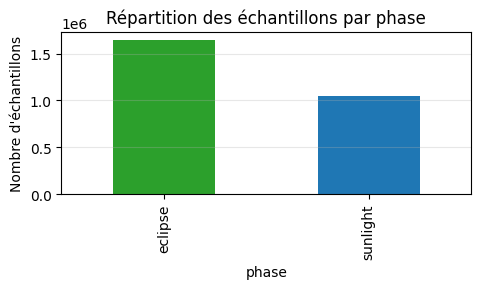

In [2]:
# [NOUVELLE CELLULE] — Aperçu global rapide
import numpy as np
import matplotlib.pyplot as plt

print("Aperçu du DataFrame:")
display(df.head())

# Estimation de la période d'échantillonnage
if len(df) > 2:
    dt = float(np.median(np.diff(df["time_s"].values)))
else:
    dt = np.nan
duree_h = (df["time_s"].iloc[-1] - df["time_s"].iloc[0]) / 3600.0

print(f"Fréquence ~ {1.0/dt:.2f} Hz (dt ≈ {dt:.2f} s)") if dt==dt else print("Fréquence: N/A")
print(f"Durée totale ≈ {duree_h:.2f} h, Orbits: {df['orbit'].nunique()}, Lignes: {len(df):,}")

# Répartition par phase
phase_counts = df["phase"].value_counts()
plt.figure(figsize=(5,3))
phase_counts.plot(kind="bar", color=["#2ca02c", "#1f77b4"])
plt.title("Répartition des échantillons par phase")
plt.ylabel("Nombre d'échantillons")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

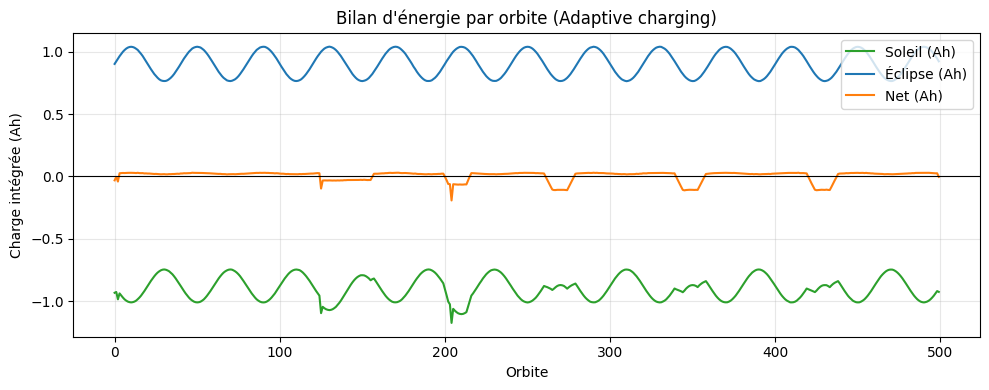

In [3]:
# [NOUVELLE CELLULE] — Bilan d'énergie (Ah) par orbite et par phase
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# période d'échantillonnage
dt = float(np.median(np.diff(df["time_s"].values))) if len(df)>2 else 1.0

# Courant intégré (Ah) par (orbit, phase)
df_energy = df.copy()
df_energy["Ah"] = df_energy["current_A"] * dt / 3600.0
ener = df_energy.groupby(["orbit", "phase"])["Ah"].sum().unstack(fill_value=0.0)

# Colonnes manquantes éventuelles
for col in ["sunlight", "eclipse"]:
    if col not in ener.columns:
        ener[col] = 0.0

ener["net_Ah"] = ener["sunlight"] + ener["eclipse"]

plt.figure(figsize=(10,4))
plt.plot(ener.index, ener["sunlight"], label="Soleil (Ah)", color="#2ca02c")
plt.plot(ener.index, ener["eclipse"], label="Éclipse (Ah)", color="#1f77b4")
plt.plot(ener.index, ener["net_Ah"], label="Net (Ah)", color="#ff7f0e")
plt.axhline(0, color="k", lw=0.8)
plt.xlabel("Orbite")
plt.ylabel("Charge intégrée (Ah)")
plt.title("Bilan d'énergie par orbite (Adaptive charging)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


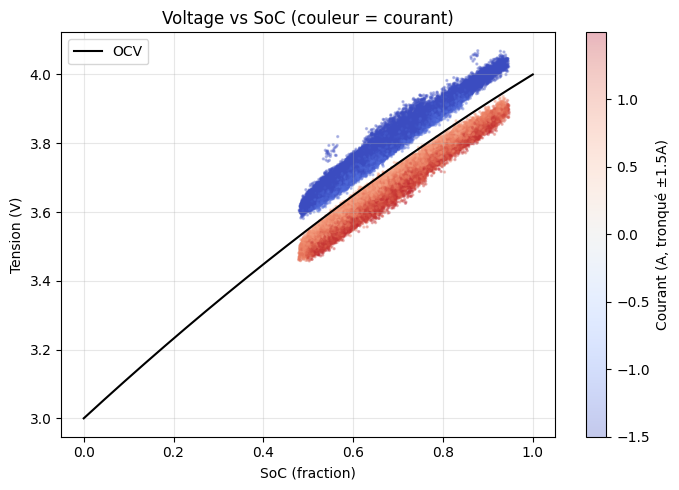

In [5]:
# [NOUVELLE CELLULE] — Carte V(SOC) colorée par courant + courbe OCV
import numpy as np
import matplotlib.pyplot as plt

# Ensure ocv_curve is available (define only if not already defined in the kernel)
if 'ocv_curve' not in globals():
    def ocv_curve(soc):
        """
        Approximate Li-ion open-circuit voltage (OCV) curve.
        soc : [0..1] or array-like
        Returns voltage in volts.
        """
        soc = np.clip(soc, 0.0, 1.0)
        return 3.0 + 1.2 * soc - 0.2 * soc**2

# Échantillonnage pour tracer rapidement
max_points = 200_000
plot_df = df.sample(n=max_points, random_state=0) if len(df) > max_points else df

plt.figure(figsize=(7,5))
sc = plt.scatter(plot_df["SoC_true"], plot_df["voltage_V"],
                 c=np.clip(plot_df["current_A"], -1.5, 1.5),
                 s=2, cmap="coolwarm", alpha=0.3)
plt.colorbar(sc, label="Courant (A, tronqué ±1.5A)")
plt.xlabel("SoC (fraction)")
plt.ylabel("Tension (V)")
plt.title("Voltage vs SoC (couleur = courant)")

# Courbe OCV théorique
soc_line = np.linspace(0, 1, 200)
plt.plot(soc_line, ocv_curve(soc_line), color="k", lw=1.5, label="OCV")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

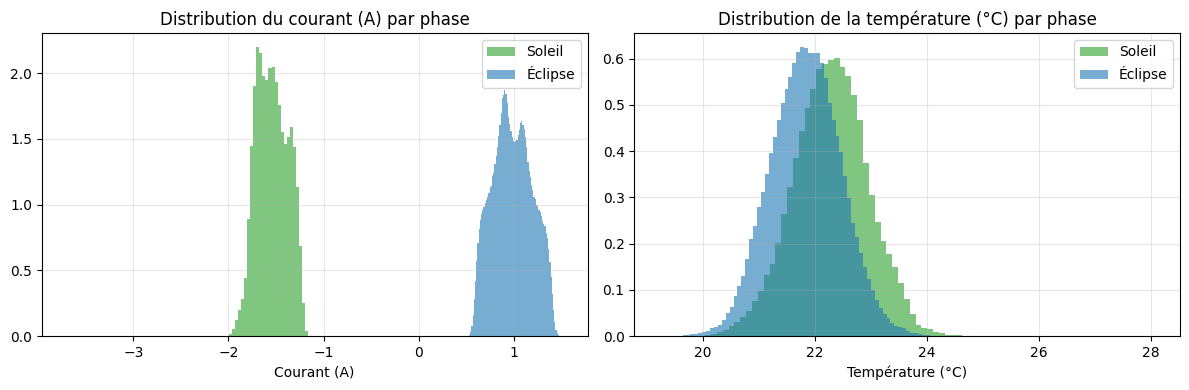

In [6]:
# [NOUVELLE CELLULE] — Distributions par phase: courant et température
import matplotlib.pyplot as plt

sun = df[df["phase"]=="sunlight"]
ecl = df[df["phase"]=="eclipse"]

fig, axs = plt.subplots(1,2, figsize=(12,4))

# Courant
axs[0].hist(sun["current_A"], bins=80, alpha=0.6, label="Soleil", color="#2ca02c", density=True)
axs[0].hist(ecl["current_A"], bins=80, alpha=0.6, label="Éclipse", color="#1f77b4", density=True)
axs[0].set_title("Distribution du courant (A) par phase")
axs[0].set_xlabel("Courant (A)")
axs[0].grid(True, alpha=0.3)
axs[0].legend()

# Température
axs[1].hist(sun["temperature_C"], bins=80, alpha=0.6, label="Soleil", color="#2ca02c", density=True)
axs[1].hist(ecl["temperature_C"], bins=80, alpha=0.6, label="Éclipse", color="#1f77b4", density=True)
axs[1].set_title("Distribution de la température (°C) par phase")
axs[1].set_xlabel("Température (°C)")
axs[1].grid(True, alpha=0.3)
axs[1].legend()

plt.tight_layout()
plt.show()

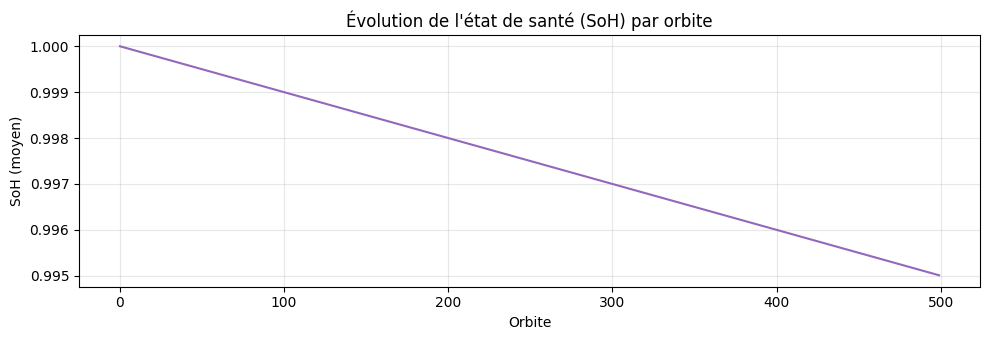

In [7]:
# [NOUVELLE CELLULE] — SoH moyen par orbite
import matplotlib.pyplot as plt

soh_orbit = df.groupby("orbit")["SoH_true"].mean()

plt.figure(figsize=(10,3.5))
plt.plot(soh_orbit.index, soh_orbit.values, color="#9467bd")
plt.xlabel("Orbite")
plt.ylabel("SoH (moyen)")
plt.title("Évolution de l'état de santé (SoH) par orbite")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

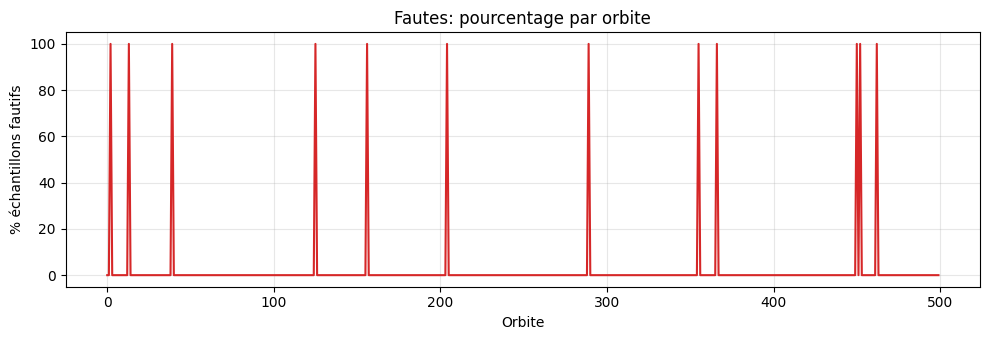

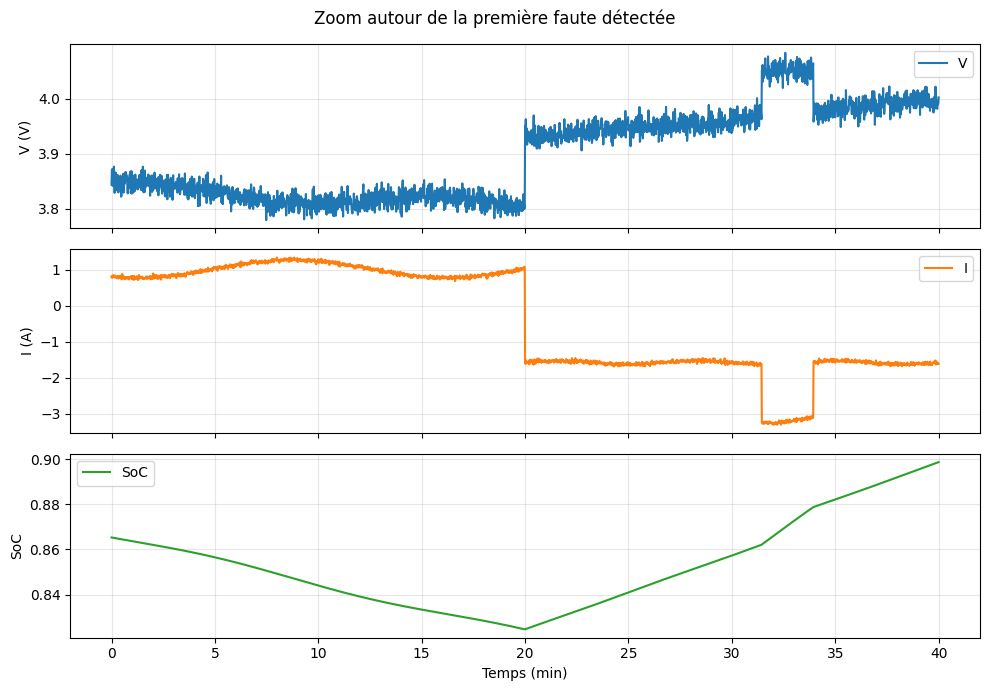

In [8]:
# [NOUVELLE CELLULE] — Fautes: taux par orbite et zoom temporel
import matplotlib.pyplot as plt
import numpy as np

fault_rate = df.groupby("orbit")["fault_flag"].mean() * 100.0

fig, ax = plt.subplots(1,1, figsize=(10,3.5))
ax.plot(fault_rate.index, fault_rate.values, color="#d62728")
ax.set_xlabel("Orbite")
ax.set_ylabel("% échantillons fautifs")
ax.set_title("Fautes: pourcentage par orbite")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Zoom autour de la première occurrence d'une faute (si présente)
fault_idx = np.where(df["fault_flag"].values==1)[0]
if fault_idx.size > 0:
    idx0 = int(fault_idx[0])
    t0 = df["time_s"].iloc[idx0]
    window_s = 20 * 60  # ±20 min
    sub = df[(df["time_s"] >= t0 - window_s) & (df["time_s"] <= t0 + window_s)]

    fig, axs = plt.subplots(3,1, figsize=(10,7), sharex=True)
    tmin = (sub["time_s"] - sub["time_s"].iloc[0]) / 60.0
    axs[0].plot(tmin, sub["voltage_V"], label="V")
    axs[1].plot(tmin, sub["current_A"], label="I", color="C1")
    axs[2].plot(tmin, sub["SoC_true"], label="SoC", color="C2")
    axs[0].set_ylabel("V (V)")
    axs[1].set_ylabel("I (A)")
    axs[2].set_ylabel("SoC")
    axs[2].set_xlabel("Temps (min)")
    for a in axs: 
        a.grid(True, alpha=0.3); a.legend()
    plt.suptitle("Zoom autour de la première faute détectée")
    plt.tight_layout()
    plt.show()
else:
    print("Aucune faute détectée dans cet ensemble.")

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import joblib

# Load data
X = np.load("cubesat_X_lstm.npy")
y = np.load("cubesat_y_lstm.npy")

# Split indices (same as before)
n_samples = len(X)
n_train = int(n_samples * 0.8)
n_val = int(n_samples * 0.1)
X_train, y_train = X[:n_train], y[:n_train]
X_val, y_val = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
X_test, y_test = X[n_train+n_val:], y[n_train+n_val:]

# Define LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

# Train
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint("best_lstm_model.keras", save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=128,
    callbacks=callbacks
)

# Evaluate
mse, mae = model.evaluate(X_test, y_test)
print(f"Test MSE: {mse:.4f}, MAE: {mae:.4f}")

# Save
model.save("final_lstm_model.keras")


c:\Users\pc\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,425 (122.75 KB)

 Trainable params: 31,425 (122.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 72s 41ms/step - loss: 0.0825 - mae: 0.2057 - val_loss: 0.0963 - val_mae: 0.2361
Epoch 2/40
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 66s 39ms/step - loss: 0.0387 - mae: 0.1391 - val_loss: 0.1126 - val_mae: 0.2422
Epoch 3/40
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 48s 28ms/step - loss: 0.0296 - mae: 0.1178 - val_loss: 0.2468 - val_mae: 0.4027
Epoch 4/40
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 70s 41ms/step - loss: 0.0178 - mae: 0.0891 - val_loss: 0.2297 - val_mae: 0.3733
Epoch 5/40
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 64s 38ms/step - loss: 0.0101 - mae: 0.0668 - val_loss: 0.2450 - val_mae: 0.3885
Epoch 6/40
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 48s 28ms/step - loss: 0.0083 - mae: 0.0601 - val_loss: 0.2289 - val_mae: 0.3603
844/844 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0642 - mae: 0.1787
Test MSE: 0.1111, MAE: 0.2420


In [10]:
"""
Step 4 — Model Evaluation & Visualization for CubeSat SoC Predictor
-------------------------------------------------------------------
This script loads the trained LSTM model, evaluates it on the test dataset,
and visualizes predictions versus ground truth (SoC(t + 15 min)).

Assumes:
 - final_lstm_model.keras  → trained LSTM model
 - cubesat_X_lstm.npy, cubesat_y_lstm.npy  → data arrays
 - cubesat_scaler.pkl  → scaler used during preprocessing
"""

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ---------------------------
# 1. Load model and data
# ---------------------------
MODEL_PATH = "final_lstm_model.keras"
SCALER_PATH = "cubesat_scaler.pkl"
X_PATH = "cubesat_X_lstm.npy"
Y_PATH = "cubesat_y_lstm.npy"

print("📥 Loading model and data...")
model = tf.keras.models.load_model(MODEL_PATH)
scaler = joblib.load(SCALER_PATH)
X = np.load(X_PATH)
y = np.load(Y_PATH)

# Split test set same way as training script
n_samples = len(X)
n_train = int(n_samples * 0.8)
n_val = int(n_samples * 0.1)
X_test = X[n_train + n_val:]
y_test = y[n_train + n_val:]
print(f"✅ Loaded: X_test={X_test.shape}, y_test={y_test.shape}")



📥 Loading model and data...
✅ Loaded: X_test=(26988, 30, 5), y_test=(26988,)


In [12]:
# ---------------------------
# 2. Make predictions
# ---------------------------
print("🔮 Making predictions...")
y_pred = model.predict(X_test, batch_size=128, verbose=1).flatten()

# ---------------------------
# 3. Inverse-transform SoC (optional, to recover physical scale)
# ---------------------------
# Create dummy array for inverse scaling
n_features = len(scaler.feature_names_in_)
dummy = np.zeros((len(y_pred), n_features))
dummy[:, -1] = y_pred  # last column is SoC_true
y_pred_inv = scaler.inverse_transform(dummy)[:, -1]

dummy[:, -1] = y_test
y_test_inv = scaler.inverse_transform(dummy)[:, -1]

# ---------------------------
# 4. Compute metrics
# ---------------------------
mae = mean_absolute_error(y_test_inv, y_pred_inv)
# Older scikit-learn versions don't support 'squared' kwarg; compute RMSE manually
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"\n📊 Evaluation Results:")
print(f"  MAE   = {mae:.4f}")
print(f"  RMSE  = {rmse:.4f}")
print(f"  R²    = {r2:.4f}")



🔮 Making predictions...
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step

📊 Evaluation Results:
  MAE   = 0.0205
  RMSE  = 0.0282
  R²    = 0.7027


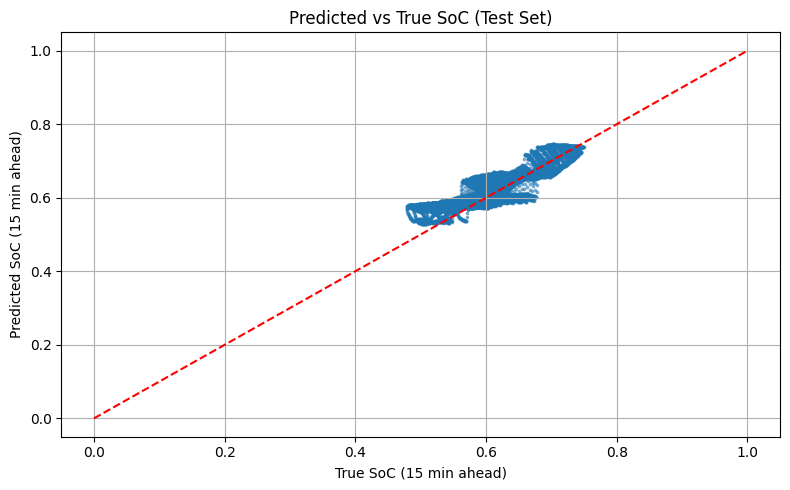

In [13]:
# ---------------------------
# 5. Visualization
# ---------------------------
plt.figure(figsize=(8,5))
plt.scatter(y_test_inv, y_pred_inv, s=3, alpha=0.5)
plt.plot([0,1],[0,1], 'r--')
plt.xlabel("True SoC (15 min ahead)")
plt.ylabel("Predicted SoC (15 min ahead)")
plt.title("Predicted vs True SoC (Test Set)")
plt.grid(True)
plt.tight_layout()
plt.show()



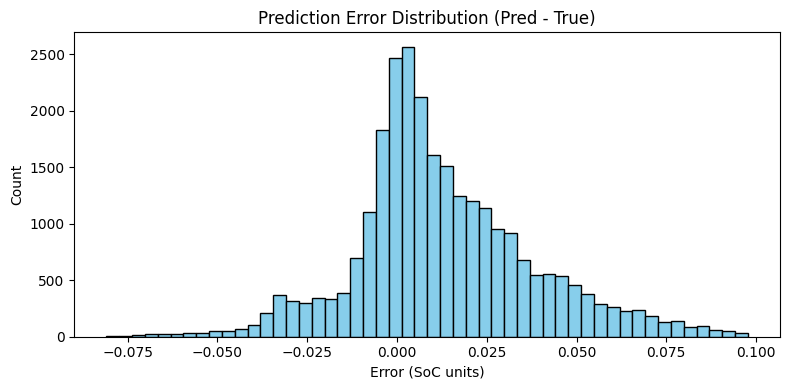

In [14]:
# ---------------------------
# 6. Error Distribution
# ---------------------------
errors = y_pred_inv - y_test_inv
plt.figure(figsize=(8,4))
plt.hist(errors, bins=50, color="skyblue", edgecolor="k")
plt.title("Prediction Error Distribution (Pred - True)")
plt.xlabel("Error (SoC units)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()



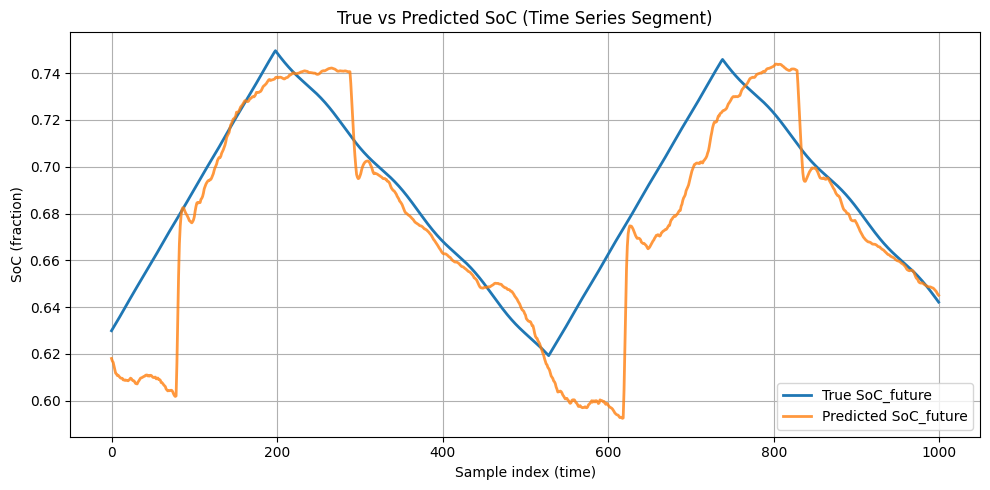

In [15]:
# ---------------------------
# 7. Time Series Visualization
# ---------------------------
# Plot a portion of test set to see temporal behavior
n_plot = 1000  # how many test samples to plot
plt.figure(figsize=(10,5))
plt.plot(y_test_inv[:n_plot], label="True SoC_future", lw=2)
plt.plot(y_pred_inv[:n_plot], label="Predicted SoC_future", lw=2, alpha=0.8)
plt.xlabel("Sample index (time)")
plt.ylabel("SoC (fraction)")
plt.title("True vs Predicted SoC (Time Series Segment)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [17]:
import tensorflow as tf

model = tf.keras.models.load_model("final_lstm_model.keras")

# Convert to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # quantization (reduce size)

# Fix: allow Select TF ops and avoid lowering TensorList ops for LSTM
# This resolves: 'tf.TensorListReserve' requires static element_shape during TFLite transform
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS,
]
converter._experimental_lower_tensor_list_ops = False

tflite_model = converter.convert()

with open("battery_predictor.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ Saved TensorFlow Lite model → battery_predictor.tflite")


INFO:tensorflow:Assets written to: C:\Users\pc\AppData\Local\Temp\tmpesjjnd3p\assets


INFO:tensorflow:Assets written to: C:\Users\pc\AppData\Local\Temp\tmpesjjnd3p\assets


Saved artifact at 'C:\Users\pc\AppData\Local\Temp\tmpesjjnd3p'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 30, 5), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2075242642800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2075247441200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2075242633824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2075204264256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2075204265136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2075204266368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2075247441904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2075204336832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2075204330848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2075204337184: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ Saved TensorFlo

In [4]:
# New cell — Test the saved TensorFlow Lite model (battery_predictor.tflite)
import numpy as np
import tensorflow as tf
import joblib

# Load one preprocessed window (already scaled like training)
X = np.load("cubesat_X_lstm.npy")                # shape: (N, 30, 5), likely float64
x_sample = X[-1:].astype(np.float32)             # shape: (1, 30, 5) and float32 for TFLite

# Create interpreter (note: tf.lite.Interpreter is deprecated, but still works)
# Optional new runtime: pip install ai-edge-litert and use:
# from ai_edge_litert.interpreter import Interpreter
interpreter = tf.lite.Interpreter(model_path="battery_predictor.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input spec:", input_details[0]["shape"], input_details[0]["dtype"])
print("Output spec:", output_details[0]["shape"], output_details[0]["dtype"])

# Set input and invoke
interpreter.set_tensor(input_details[0]["index"], x_sample)
interpreter.invoke()

y_pred_scaled = interpreter.get_tensor(output_details[0]["index"]).flatten()
print("Scaled prediction:", float(y_pred_scaled[0]))

# Optional: inverse-transform to physical SoC using the saved scaler
scaler = joblib.load("cubesat_scaler.pkl")
n_features = len(scaler.feature_names_in_)
dummy = np.zeros((1, n_features), dtype=np.float32)
dummy[0, -1] = y_pred_scaled[0]                 # last feature is SoC_true per your FEATURES
y_pred_soc = scaler.inverse_transform(dummy)[0, -1]
print("Predicted SoC (fraction):", float(y_pred_soc))

Input spec: [ 1 30  5] <class 'numpy.float32'>
Output spec: [1 1] <class 'numpy.float32'>
Scaled prediction: -0.7878696322441101
Predicted SoC (fraction): 0.5770459771156311
